### Collaborative Filterting on MovieLens Dataset

#### Importing required packages and modules

In [1]:
import io # Input and output streams handling
import os # Directory operations
import math # Mathematical functions and constants
import copy # Deep copies of objects
import pickle # Python objects serializing and deserializing
import zipfile # ZIP archives

from pathlib import Path # File paths and directories operations
from itertools import zip_longest # Multiple iterables items grouping

from urllib.error import URLError # URL-related errors handling
from urllib.request import urlopen # Open URL-s

# No need to describe :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler # Learning rate scheduler

In [2]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)
        
set_random_seed()

**Dataset Downloading**

In [3]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

In [4]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python', encoding='latin-1')
            files[filename.stem] = data
    return files['ratings'], files['movies']

In [5]:
# pick any other dataset instead
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
download_path = Path.home() / 'Desktop' / 'ACA'

In [6]:
try_download(archive_url, download_path)

The archive is extracted into folder: C:\Users\Aren\Desktop\ACA


In [7]:
# pick one of the available folders
ratings, movies = read_data(download_path /'ml-1m')

#### Dataset Preview

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [11]:
tabular_preview(ratings, movies)

movieId,110,260,480,589,593,608,1196,1198,1210,1270,1580,2028,2571,2762,2858
userId,,,,,,,,,,,,,,,
889,4.0,4.0,3.0,5.0,5.0,4.0,4.0,NaN,3.0,4.0,3.0,3.0,5.0,NaN,2.0
1015,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0
1150,2.0,5.0,NaN,2.0,3.0,5.0,4.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,4.0
1181,3.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,3.0
1449,3.0,3.0,2.0,2.0,5.0,5.0,3.0,4.0,2.0,2.0,4.0,3.0,4.0,4.0,4.0
1680,1.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0
1941,5.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,1.0
1980,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0
2063,5.0,4.0,4.0,2.0,5.0,2.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,4.0,5.0


**Dataset Preparation**

In [12]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [13]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


In [17]:
class ReviewsIterator:
    """
    A custom iterator class for efficiently iterating through batches of reviews and labels.

    Args:
    X (numpy.ndarray): Input data, such as reviews.
    y (numpy.ndarray): Corresponding labels for the input data.
    batch_size (int, optional): Number of samples per batch. Default is 32.
    shuffle (bool, optional): Whether to shuffle the data before iterating. Default is True.

    Attributes:
    X (numpy.ndarray): The input data.
    y (numpy.ndarray): The corresponding labels.
    batch_size (int): The batch size.
    shuffle (bool): Indicates whether data should be shuffled.
    n_batches (int): Total number of batches.
    _current (int): Current batch index during iteration.

    Methods:
    __iter__(): Returns itself as an iterator.
    __next__(): Returns the result of next().
    next(): Retrieves the next batch of data and labels.

    Example:
    iterator = ReviewsIterator(X_train, y_train, batch_size=64, shuffle=True)
    for batch_X, batch_y in iterator:
        # Process the batch of data and labels
    """

    def __init__(self, X, y, batch_size=32, shuffle=True):
        # Convert input data and labels to numpy arrays
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            # Shuffle the data by generating a random permutation of indices
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] / batch_size))  # Calculate total number of batches
        self._current = 0

    def __iter__(self):
        """Return the iterator object itself."""
        return self

    def __next__(self):
        """Return the result of the next() method."""
        return self.next()

    def next(self):
        """
        Retrieve the next batch of data and labels.

        Returns:
        tuple: A tuple containing the batch of data (reviews) and corresponding labels.

        Raises:
        StopIteration: When all batches have been iterated.
        """
        if self._current >= self.n_batches:
            raise StopIteration()  # Stop iteration if all batches have been processed
        
        k = self._current  # Current batch index
        self._current += 1  # Move to the next batch
        bs = self.batch_size  # Batch size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]

In [18]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [19]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[3808, 2234],
        [1388,  143],
        [4509,  849],
        [1016, 2393]])
tensor([[4.],
        [4.],
        [2.],
        [3.]])


**Embeddings**

As it is a natural language dataset, embedding has to be done. It has been done here with neural based embedding, we can also try other embedding methods availble like word2vec, glove or Onehot encoding.

In [20]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers for collaborative filtering.

    Args:
        n_users (int):
            Number of unique users in the dataset.
        n_movies (int):
            Number of unique movies in the dataset.
        n_factors (int, optional):
            Number of columns in the embeddings matrix. Default is 50.
        embedding_dropout (float, optional):
            Dropout rate to apply right after embeddings layer. Default is 0.02.
        hidden (int or list of int, optional):
            A single integer or a list of integers defining the number of units in hidden layer(s).
            Default is 10.
        dropouts (float or list of float, optional):
            A single float or a list of floats defining the dropout layers rates applied right after each of hidden layers.
            Default is 0.2.

    Methods:
        forward(users, movies, minmax=None):
            Forward pass through the network.
        _init():
            Setup embeddings and hidden layers with reasonable initial values.

    Example:
        net = EmbeddingNet(n_users=100, n_movies=200, n_factors=50, embedding_dropout=0.1, hidden=[20, 10], dropouts=[0.2, 0.3])
        users = torch.tensor([1, 2, 3])
        movies = torch.tensor([4, 5, 6])
        predictions = net(users, movies, minmax=(1, 5))
    """

    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02,
                 hidden=10, dropouts=0.2):

        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and
            their activations/dropouts.

            Note that the function captures `hidden` and `dropouts`
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, users, movies, minmax=None):
        """
        Perform a forward pass through the network.

        Args:
            users (tensor):
                Tensor containing user indices.
            movies (tensor):
                Tensor containing movie indices.
            minmax (tuple, optional):
                Tuple containing the minimum and maximum rating values.
                If provided, the output predictions will be scaled accordingly.
                Default is None.

        Returns:
            tensor: Predicted ratings.
        """
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out * (max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    """
    Convert input to a list.

    Args:
        n (int, float, or iterable):
            Input to be converted to a list.

    Returns:
        list: A list containing the input.
    """
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuration should be a single number or a list of numbers')

In [21]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [22]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

**Cyclical Learning Rate (CLR)**

The base PyTorch scheduler class has the get_lr() method that is invoked each time when we call the step() method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value.

The next cell defines a CyclicLR class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [23]:
from torch.optim.lr_scheduler import _LRScheduler

class CyclicLR(_LRScheduler):
    """
    Implements a cyclic learning rate scheduler based on a custom schedule function.

    Args:
        optimizer (Optimizer):
            Wrapped optimizer.
        schedule (callable):
            A function that takes the current epoch and learning rate as input and returns the desired learning rate.
        last_epoch (int, optional):
            The index of the last epoch. Default is -1.

    Methods:
        get_lr():
            Get the learning rates for each parameter group based on the provided schedule function.

    Example:
        def custom_schedule(epoch, lr):
            return lr * (0.5 ** (epoch // 10))
        
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        scheduler = CyclicLR(optimizer, schedule=custom_schedule)
        for epoch in range(100):
            scheduler.step()
            train_model()
    """

    def __init__(self, optimizer, schedule, last_epoch=-1):
        """
        Initialize the CyclicLR scheduler.

        Args:
            optimizer (Optimizer):
                Wrapped optimizer.
            schedule (callable):
                A function that takes the current epoch and learning rate as input and returns the desired learning rate.
            last_epoch (int, optional):
                The index of the last epoch. Default is -1.
        """
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """
        Get the learning rates for each parameter group based on the provided schedule function.

        Returns:
            list: A list of learning rates for each parameter group.
        """
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [24]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    """
    Create a learning rate scheduler based on the triangular or exp_range policy.

    Args:
        step_size (int):
            The number of iterations in half a cycle.
        max_lr (float):
            The maximum learning rate.
        method (str, optional):
            The method of cycling. Can be one of 'triangular', 'triangular2', or 'exp_range'.
            Default is 'triangular'.
        gamma (float, optional):
            The multiplicative factor by which the learning rate is decayed in 'exp_range' method.
            Default is 0.99.

    Returns:
        callable: A learning rate scheduler function.

    Example:
        def custom_schedule(epoch, lr):
            return lr * (0.5 ** (epoch // 10))

        step_size = 500
        max_lr = 0.1
        scheduler = triangular(step_size, max_lr, method='triangular')
        for epoch in range(100):
            current_lr = scheduler(epoch, base_lr)
            train_model(current_lr)
    """

    def scheduler(epoch, base_lr):
        """
        Calculate the learning rate based on the specified policy.

        Args:
            epoch (int):
                The current epoch.
            base_lr (float):
                The base learning rate.

        Returns:
            float: The calculated learning rate.
        """
        period = 2 * step_size
        cycle = math.floor(1 + epoch / period)
        x = abs(epoch / step_size - 2 * cycle + 1)
        delta = (max_lr - base_lr) * max(0, (1 - x))

        if method == 'triangular':
            pass  # No further modification needed for the 'triangular' method
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma ** epoch)
        else:
            raise ValueError('unexpected method: %s' % method)

        return base_lr + delta

    return scheduler

In [25]:
def cosine(t_max, eta_min=0):
    """
    Create a learning rate scheduler based on the cosine annealing policy.

    Args:
        t_max (int):
            The number of iterations in a half cycle (period).
        eta_min (float, optional):
            The minimum learning rate. Default is 0.

    Returns:
        callable: A learning rate scheduler function.

    Example:
        def custom_schedule(epoch, lr):
            return lr * (0.5 ** (epoch // 10))

        t_max = 500
        scheduler = cosine(t_max, eta_min=0.001)
        for epoch in range(100):
            current_lr = scheduler(epoch, base_lr)
            train_model(current_lr)
    """

    def scheduler(epoch, base_lr):
        """
        Calculate the learning rate based on the cosine annealing policy.

        Args:
            epoch (int):
                The current epoch.
            base_lr (float):
                The base learning rate.

        Returns:
            float: The calculated learning rate.
        """
        t = epoch % t_max
        return eta_min + (base_lr - eta_min) * (1 + math.cos(math.pi * t / t_max)) / 2

    return scheduler

In [26]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

**Training Loop**

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [28]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())

In [29]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=100, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [30]:
lr = 5e-5 # Learning rate
bs = 500 # Batch size
n_epochs = 100 # Iterations
patience = 20 # Early stopping in case of 20 epochs with no improvements

# Parameters initialization
no_improvements = 0
best_loss = np.inf
best_weights = None

history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

class NRMSELoss(nn.Module):
    def __init__(self):
        super(NRMSELoss, self).__init__()

    def forward(self, predicted, target):
        mse_loss = nn.MSELoss(reduction='sum')(predicted, target)
        range_value = target.max() - target.min()
        nrmse_loss = torch.sqrt(mse_loss) / range_value
        return nrmse_loss

criterion = NRMSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [31]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/100] train: 0.0113 - val: 0.0105
loss improvement on epoch: 2
[002/100] train: 0.0104 - val: 0.0104
loss improvement on epoch: 3
[003/100] train: 0.0103 - val: 0.0103
loss improvement on epoch: 4
[004/100] train: 0.0102 - val: 0.0103
loss improvement on epoch: 5
[005/100] train: 0.0102 - val: 0.0103
loss improvement on epoch: 6
[006/100] train: 0.0101 - val: 0.0102
loss improvement on epoch: 7
[007/100] train: 0.0101 - val: 0.0102
loss improvement on epoch: 8
[008/100] train: 0.0100 - val: 0.0102
loss improvement on epoch: 9
[009/100] train: 0.0101 - val: 0.0102
loss improvement on epoch: 10
[010/100] train: 0.0100 - val: 0.0102
loss improvement on epoch: 11
[011/100] train: 0.0100 - val: 0.0101
loss improvement on epoch: 12
[012/100] train: 0.0099 - val: 0.0101
loss improvement on epoch: 13
[013/100] train: 0.0100 - val: 0.0101
loss improvement on epoch: 14
[014/100] train: 0.0099 - val: 0.0101
loss improvement on epoch: 15
[015/100] train: 0.0099 - v

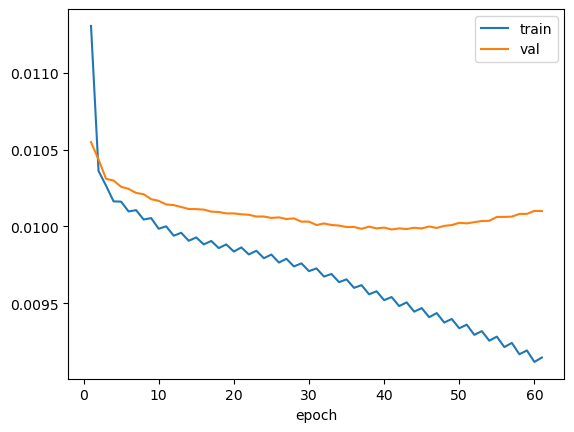

In [32]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

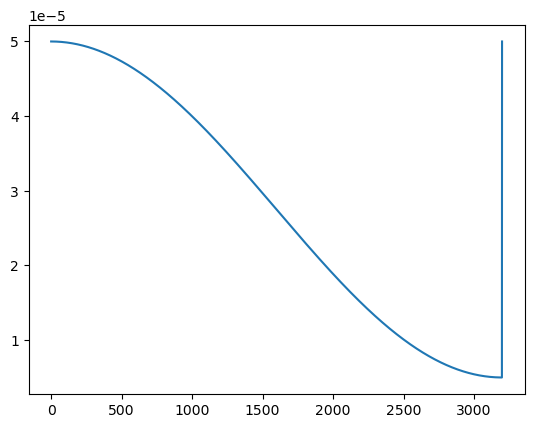

In [33]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [34]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [35]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [36]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)